In [1]:
import os
from rosemary import jpt_setup; jpt_setup()

from transformers.trainer_utils import get_last_checkpoint

import re
from llm.submit import (
    multiline_to_singleline,
    submit_job_ccc,
    submit_job_aimos,
    submit_job,
    get_run_statistics)
import pandas as pd
import json
import platform
import tempfile
import subprocess
import shlex
import datetime
import itertools
import socket
import glob

import base64
string_to_alphanumeric = lambda s: base64.urlsafe_b64encode(s.encode('utf-8')).decode('utf-8')
alphanumeric_to_string = lambda a: base64.urlsafe_b64decode(a).decode('utf-8')

arch = platform.uname().processor
hostname = socket.gethostname()
cluster = 'ccc' if hostname.startswith('ccc') else ('dcs' if hostname.startswith('dcs') else 'npl')
arch, cluster

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


('ppc64le', 'dcs')

# Finetuning with openinstruct/finetune.py


In [3]:
# job_name = 'ft'
# test_run = 1
# test_run = bool(test_run)

# queue = 'x86_12h' # 'x86_12h'
# num_cpus = 20
# num_gpus = 1
# cpu_mem = 32
# require = 'a100_80gb'

# # model_name_or_path = 'mosaicml/mpt-7b'; max_seq_length = 2048
# # model_name_or_path = 'gpt2'; max_seq_length = 1024
# # model_name_or_path = 'gpt2-Large'; max_seq_length = 1024
# # model_name_or_path = 'gpt2-xl'; max_seq_length = 1024
# model_name_or_path = 'huggyllama/llama-7b'; max_seq_length = 2048


# train_file = 'data/processed/oasst1/oasst1_data.jsonl'; train_file_short = 'oasst1'
# train_file = 'data/processed/flanv2_cot_oasst1_dolly.jsonl'; train_file_short = 'human_mix'
# # train_file = 'data/processed/flanv2_cot_oasst1_dolly_shuffled.jsonl'; train_file_short = 'human_mix_shuffled'

# output_dir = f"results/{model_name_or_path.replace('/', ':')}_{train_file_short}"
# if test_run:
#     output_dir = 'jpt_' + output_dir

# use_deepspeed = False
# # deepspeed_config_file = 'ds_configs/stage3_no_offloading_accelerate_setauto.conf'
# # deepspeed_config_file = 'ds_configs/stage3_offloading_accelerate.conf'
# deepspeed_config_file = 'ds_configs/stage3_offloading_accelerate_setauto.conf'

# use_lora = True
# lora_rank = 4
# lora_alpha = lora_rank
# lora_dropout = 0.05

# batch_size_per_gpu = 1
# total_batch_size = 128
# mixed_precision = 'bf16' # 'bf16', 'fp16'
# checkpointing_steps = None # every n steps, where n='1' or every 'epoch'

# gradient_acc_steps = int(total_batch_size/num_gpus/batch_size_per_gpu)

# print(f"Training {model_name_or_path} "
#       f"using {num_gpus} GPUs, "
#       f"{batch_size_per_gpu} batch size per GPU, "
#       f"{gradient_acc_steps} gradient accumulation steps.")

# # do use fast tokenizer since mpt-7b does not have a fast tokenizer counter-part
# #     --use_slow_tokenizer \
# # do not use flash attention, since having problem installing flash-attn with cuda 12.1
# #     --use_flash_attn \

# cmd = f"""
# {'!cd .. && ' if test_run else ''}accelerate launch \
#     --mixed_precision {mixed_precision} \
#     --num_machines 1 \
#     --num_processes {num_gpus} \
#     {'--use_deepspeed' if use_deepspeed else ''}
#     {'--deepspeed_config_file '+deepspeed_config_file if use_deepspeed else ''}
#     open_instruct/finetune.py \
#     --model_name_or_path {model_name_or_path} \
#     --tokenizer_name {model_name_or_path} \
#     --train_file {train_file} \
#     --max_seq_length {max_seq_length} \
#     {'--use_lora' if use_lora else ''}
#     --lora_rank {lora_rank} \
#     --lora_alpha {lora_alpha} \
#     --lora_dropout {lora_dropout} \
#     --preprocessing_num_workers 16 \
#     --per_device_train_batch_size {batch_size_per_gpu} \
#     --gradient_accumulation_steps {gradient_acc_steps} \
#     --learning_rate 2e-5 \
#     --lr_scheduler_type linear \
#     --warmup_ratio 0.03 \
#     --weight_decay 0. \
#     --num_train_epochs 2 \
#     --output_dir {output_dir} \
#     --with_tracking \
#     --report_to tensorboard \
#     {'--checkpointing_steps '+str(checkpointing_steps) if checkpointing_steps else ''}
#     --logging_steps 1
# """

# # things to test to see its effects on (1) eval perf (2) runtime.
# #
# # - int8
# # - mixed_precision bf16 or no
# # - with/without LoRA
# # - LoRA's rank/alpha (alpha typically set to 2*rank)
# # - batch size
# # - micro-batch size (largest without running out of memory)


# cmd = multiline_to_singleline(cmd)
# if test_run:
#     print()
#     print(cmd)

# shell_scripts = shell_scripts_template.format(
#     cmd=cmd,
#     log_dir=os.getcwd(),
#     save_dir=output_dir)
# out = submit_job_ccc(
#     shell_scripts, 
#     job_name=job_name, 
#     queue=queue,
#     num_cpus=num_cpus,
#     cpu_mem=cpu_mem,
#     require=require,
#     num_gpus=num_gpus,
#     test_run=test_run,
# )
# if not test_run:
#     print(out)

In [4]:
# llama7b+lora, micro-bsz=1, bsz=128, 
#     66gb gpu mem, in it 28gb for torch tensor. so fit on 1 a100_80gb

#   1%|▏         | 57/4222 [22:24<25:53:47, 22.38s/it]07/11/2023 23:13:55 - INFO - 
# __main__ -   Step: 57, LR: 9.047619047619049e-06, Loss: 2.2924644947052
# 


# !cd .. && accelerate launch --mixed_precision bf16 --num_machines 1 --num_processes 1 open_instruct/finetune.py --model_name_or_path huggyllama/llama-7b --tokenizer_name huggyllama/llama-7b --train_file data/processed/flanv2_cot_oasst1_dolly.jsonl --max_seq_length 2048 --use_lora --lora_rank 4 --lora_alpha 4 --lora_dropout 0.05 --preprocessing_num_workers 16 --per_device_train_batch_size 1 --gradient_accumulation_steps 128 --learning_rate 2e-5 --lr_scheduler_type linear --warmup_ratio 0.03 --weight_decay 0. --num_train_epochs 2 --output_dir results/huggyllama:llama-7b_human_mixjpt_results/huggyllama:llama-7b_human_mix --with_tracking --report_to tensorboard --logging_steps 1





# Finetuning with openinstruct/finetune_trainer.py


In [2]:
# runtime:
# shared: humanmix, max_sequence_length=2048.
# just a single process if num_gpus=1 otherwise use python fsdp with gradient-checkpointing.
#
# llama7b, micro-bsz=2, grad-ckpt, 2xa100_80gb: 27s/it, 32hrs
# 
# llama7b+lora(r=4),   micro-bsz=1, no-grad-ckpt,a100_80gb: 27s/it, 32hrs, 66gb gpu mem
# llama7b+lora(r=16),  micro-bsz=1, no-grad-ckpt,a100_80gb: 24s/it, 28hrs, 67gb gpu mem
# llama7b+lora(r=256), micro-bsz=1, no-grad-ckpt,a100_80gb: 24s/it, 28hrs, 70gb gpu mem
#
# llama7b+lora(r=4),   micro-bsz=1,  grad-ckpt,  a100_80gb: 32s/it, 38hrs
# llama7b+lora(r=256), micro-bsz=1,  grad-ckpt,  a100_80gb, 37s/it, 43hrs# llama7b+lora(r=4),   micro-bsz=2,  grad-ckpt,  a100_80gb: 32s/it, 38hrs (+20% runtime with grad-ckpt)
# llama7b+lora(r=4),   micro-bsz=16, grad-ckpt,  a100_80gb: 68s/it, 80hrs, 75gb gpu mem
# llama7b+lora(r=128), micro-bsz=16, grad-ckpt,  a100_80gb: 70s/it, 82hrs
# 
# take-aways
# - larger batch should speed up training. however, it also implies that the batch 
#   will be padded to longer sequence length, due to chat data, thereby increasing
#   compute required to process a batch. Therefore, micro-bsz=1 seems to be ok.
#

# aimos
# shared: humanmix, max_sequence_length=2048. 1 node = 6x v100_32gb

# take-aways: 
#   (1) fsdp (v4.28.1, v4.32.0.dev0 are pretty similar in terms of speed. don't use v4.31.0)
#   (2) micro-bsz=1->2 seems to be the best here. leads to ~30% reduction in runtime.
#   (3) increasing #nodes almost linear reduction in time, e.g., Use 4x nodes cost 30% time (25% if linear.)

# llama7b, micro-bsz=1, fsdp, grad-ckpt, float16, mp=none, nodes=1, 74s/it, 89hrs, loss=0
# llama7b, micro-bsz=1, fsdp, grad-ckpt, float16, mp=fp16, nodes=1, 72s/it, 86hrs
# llama7b, micro-bsz=2, fsdp, grad-ckpt, float16, mp=none, nodes=1, 52s/it, 66hrs, loss=0
# llama7b, micro-bsz=2, fsdp, grad-ckpt, float16, mp=fp16, nodes=1, 49s/it, 61hrs
# - resume from lastest checkpt (trained 4.28.1, resume 4.32.0.dev0), did
#   did not found `optimizer.bin` 
# llama7b, micro-bsz=3, fsdp, grad-ckpt, float16, mp=fp16, nodes=1, oom
# llama7b, micro-bsz=3, fsdp, grad-ckpt, float16, mp=none, nodes=1, oom
# llama7b, micro-bsz=4, fsdp, grad-ckpt, float16, mp=fp16, nodes=1, oom
# llama7b, micro-bsz=4, fsdp, grad-ckpt, float16, mp=none, nodes=1, oom
# llama7b, micro-bsz=1, fsdp, no-grad-ckpt, float16, mp=fp16, nodes=1, oom
# llama7b, micro-bsz=2, fsdp, no-grad-ckpt, float16, mp=fp16, nodes=1, oom
# # nodes > 1
# llama7b, micro-bsz=2, fsdp, grad-ckpt, float16, mp=fp16, nodes=4, 14s/it, 18hrs

# take-away: 
#   (1) torch_dtype=float16 gives loss=0. setting torch_dtype=float32 solves the issue but takes more memory and compute
#   (2) mbsz=2 oom for nodes=1 but works fine with nodes=2. more nodes -> potentially larger mbsz.

# llama7b, micro-bsz=1, fsdp, grad-ckpt, float32, mp=none, nodes=1, oom
# llama7b, micro-bsz=2, fsdp, grad-ckpt, float32, mp=none, nodes=1, oom
# llama7b, micro-bsz=1, fsdp, grad-ckpt, float32, mp=fp16, nodes=1, 139s/it, 166hrs
# llama7b, micro-bsz=2, fsdp, grad-ckpt, float32, mp=fp16, nodes=1, oom
# llama7b, micro-bsz=2, fsdp, grad-ckpt, float32, mp=fp16, nodes=2, 33s/it, 41hrs, loss!=0
# llama7b, micro-bsz=2, fsdp, grad-ckpt, float32, mp=fp16, nodes=4, 17s/it, 21hrs
# llama7b, micro-bsz=3, fsdp, grad-ckpt, float32, mp=fp16, nodes=4, 18s/it, 21hrs
# llama7b, micro-bsz=4, fsdp, grad-ckpt, float32, mp=fp16, nodes=4, oom
# llama7b, micro-bsz=2, fsdp, grad-ckpt, float32, mp=fp16, nodes=5, 4s/it, 21.7hrs


#
# deepspeed
# shared: llama7b, deepspeed, grad-ckpt
# take-aways
#   (1) with deepspeed, using mixed-precision gives x50% speed improvement
#   (2) no loss overflow issues. deepspeed has good mixed-precision integration, loss_scaler handles it.
# 
# llama7b, micro-bsz=1, deepspeed(s=3,offload), float32, mp=fp16, nodes=1, 161s/it, 192hrs, loss ok, loss_scaler early on in use.
# llama7b, micro-bsz=1, deepspeed(s=3,offload), float32, mp=none, nodes=1, 259s/it, 309hrs, loss ok.
# llama7b, micro-bsz=1, deepspeed(s=3,offload), float16, mp=fp16, nodes=1, 169s/it, 202hrs, loss ok. loss_scaler early on in use.
# llama7b, micro-bsz=1, deepspeed(s=3,offload), float16, mp=none, nodes=1, 258s/it, 307hrs, loss ok.
#
# llama7b, micro-bsz=2, deepspeed(s=3,offload), float32, mp=fp16, nodes=1, 108s/it, 135hrs, loss ok.
# llama7b, micro-bsz=4, deepspeed(s=3,offload), float32, mp=fp16, nodes=1,  96s/it, 120hrs, loss ok.
# llama7b, micro-bsz=1, deepspeed(s=3), float32, mp=fp16, nodes=1, 123s/it, 147hrs, loss ok.
# llama7b, micro-bsz=2, deepspeed(s=3), float32, mp=fp16, nodes=1, 66s/it, 83hrs, loss ok.
# llama7b, micro-bsz=4, deepspeed(s=3), float32, mp=fp16, nodes=1, oom
#
# nodes>1
# llama7b, micro-bsz=2, deepspeed(s=3), float32, mp=fp16, nodes=2, error with downloading config.json
# llama7b, micro-bsz=2, deepspeed(s=3), float32, mp=fp16, nodes=4, 
# llama7b, micro-bsz=4, deepspeed(s=3), float32, mp=fp16, nodes=4, 16s/it, 21hrs
# llama7b, micro-bsz=6, deepspeed(s=3), float32, mp=fp16, nodes=4,  3s/it, 17hrs


# 1 node, 1 v100_32gb, no-grad-ckpt, nodes=1
#
# gpt2, micro-bsz=1, float32, mp=16, 7s/it, 8.6hrs
# gpt2, micro-bsz=2, float32, mp=16, 5s/it, 5.6hrs
# gpt2, micro-bsz=4, float32, mp=16, 5s/it, 6.3hrs
# gpt2, micro-bsz=8, float32, mp=16, 6s/it, 6.6hrs
# gpt2, micro-bsz=16, float32, mp=16, oom
# gpt2-medium, micro-bsz=2, float32, mp=16, 14s/it, 17.0hrs
# gpt2-medium, micro-bsz=2, float32, mp=16, 10s/it, 12.2hrs
# gpt2-medium, micro-bsz=4, float32, mp=16, oom
# gpt2-medium, micro-bsz=8, float32, mp=16, oom
# 


shell_scripts_template_slurm = """
echo "Running on $SLURM_JOB_NODELIST"
echo "======"

master_addr=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
master_port=10002
RDZV_ENDPOINT=$master_addr:$master_port

source ~/.profile
conda activate open-instruct
cd /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/

set -e
set -x
echo "======"
srun {cmd}

[ ! -f "{log_dir}/$SLURM_JOB_ID*.out" ] && mv {log_dir}/$SLURM_JOB_ID*.out {save_dir}
"""

shell_scripts_template_lsf = """
echo "Running on $LSB_DJOB_HOSTFILE"
echo "======"

master_addr=$(head -n 1 "$LSB_DJOB_HOSTFILE")
master_port=10002
RDZV_ENDPOINT=$master_addr:$master_port

source ~/.profile
conda activate open-instruct
cd /dccstor/mit_fm/wpq/github/mitibm2023/external/open-instruct/

set -e
set -x
echo "======"
srun {cmd}

[ ! -f "{log_dir}/$LSB_JOBID*.out" ] && mv {log_dir}/$LSB_JOBID*.out {save_dir}
"""

shell_scripts_template = shell_scripts_template_slurm \
    if arch == 'ppc64le' else shell_scripts_template_lsf

print(shell_scripts_template)


echo "Running on $SLURM_JOB_NODELIST"
echo "======"

master_addr=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
master_port=10002
RDZV_ENDPOINT=$master_addr:$master_port

source ~/.profile
conda activate open-instruct
cd /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/

set -e
set -x
echo "======"
srun {cmd}

[ ! -f "{log_dir}/$SLURM_JOB_ID*.out" ] && mv {log_dir}/$SLURM_JOB_ID*.out {save_dir}



In [6]:
t = '00:33:12'
n = 15
# total = 1515; nnodes = 1
# total = 2083; nnodes = 1
total = 1587; nnodes = 1
# total = 1041; nnodes = 1
# total = 4228; nnodes = 1
# total = 4512; nnodes = 4
# total = 4296; nnodes = 1
# total = 2254; nnodes = 2
# total = 1128; nnodes = 4
# total = 1074; nnodes = 4
# total = 1252; nnodes = 4

l = [int(x) for x in t.split(':')]
t = l[0]*60*60+l[1]*60+l[2]
# t = t/60/60 # in hr

print(f'{t/n/nnodes:.0f}s/it, {t/n*total/60/60:.1f}hrs')

133s/it, 58.5hrs


In [7]:
l = []
p = '../data/processed/'
for x in os.listdir(p):
    y = os.path.join(p, x)
    if os.path.isdir(y):
        d = os.path.join(y, os.listdir(y)[0])
    else:
        continue
    d = d[3:]
    if 'shuffled' in d:
        continue
#     print(f"train_file = '{d}'; abbr_train_file = '{x}'")
    print(x)

cot
sharegpt
dolly
gpt4_alpaca
flan_v2
super_ni
stanford_alpaca
baize
code_alpaca
self_instruct
unnatural_instructions
oasst1


In [5]:


# how to sample mixture sample size?
# 
# approaches: 
# (1) want sufficient coverage for #datapoints/dataset, #datasets used, total sample size.
#  Use 5k as a unit of data, sample different #unit/dataset, and vary total units of data.
# (2) specify a total sample size and a mixture weight. this answers the question, given a 
#  fixed compute budget, what is the optimal mixture. this seems to be a simpler approach.
#
# experiments
# (1) first use samples from a single dataset for tuning. 
# (2)
# 


datasets = ['baize', 'code_alpaca', 'cot', 'dolly', 'flan_v2', 'gpt4_alpaca', 'oasst1', 'self_instruct', 'sharegpt', 'stanford_alpaca', 'super_ni', 'unnatural_instructions']
total_data_points = 200000

subsample_mixture_list = []
subsample_mixture_list += [
    {k: 100000} for k in datasets if k != 'flan_v2'
]
subsample_mixture_list += [
    {k: int(total_data_points/4) for k in ['cot', 'flan_v2', 'dolly', 'oasst1']}
]
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {'cot': 0.48785105, 'flan_v2': 0.48785105, 'dolly': 0.00732313, 'oasst1': 0.01697478}.items())
]
subsample_mixture_list += [
    {k: int(total_data_points/len(datasets)) for k in datasets} 
]
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {'cot': .07678, 'flan_v2': .9137, 'dolly': .004471, 'oasst1': .009072}.items())
]
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {'cot': 0.1127, 'flan_v2': 0.8726, 'dolly': 0.01395, 'oasst1': 0.001391}.items())
]
subsample_mixture_list

[{'baize': 100000},
 {'code_alpaca': 100000},
 {'cot': 100000},
 {'dolly': 100000},
 {'gpt4_alpaca': 100000},
 {'oasst1': 100000},
 {'self_instruct': 100000},
 {'sharegpt': 100000},
 {'stanford_alpaca': 100000},
 {'super_ni': 100000},
 {'unnatural_instructions': 100000},
 {'cot': 50000, 'flan_v2': 50000, 'dolly': 50000, 'oasst1': 50000},
 {'cot': 97570, 'flan_v2': 97570, 'dolly': 1464, 'oasst1': 3394},
 {'baize': 16666,
  'code_alpaca': 16666,
  'cot': 16666,
  'dolly': 16666,
  'flan_v2': 16666,
  'gpt4_alpaca': 16666,
  'oasst1': 16666,
  'self_instruct': 16666,
  'sharegpt': 16666,
  'stanford_alpaca': 16666,
  'super_ni': 16666,
  'unnatural_instructions': 16666},
 {'cot': 15356, 'flan_v2': 182740, 'dolly': 894, 'oasst1': 1814},
 {'cot': 22540, 'flan_v2': 174520, 'dolly': 2790, 'oasst1': 278}]

In [7]:
from datasets import load_dataset

dataset = load_dataset("lhoestq/demo1")
dataset['train'].select([0,0])['id']

Found cached dataset csv (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/lhoestq___csv/lhoestq--demo1-ea767574a693953b/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/2 [00:00<?, ?it/s]

['7bd227d9-afc9-11e6-aba1-c4b301cdf627',
 '7bd227d9-afc9-11e6-aba1-c4b301cdf627']

In [30]:

# ft1: reproduce open-instruct table with llama7b
job_name = 'ft1'

# ft2: test mixture weights
# vary mixture weights
job_name = 'ft2'

# oi3: instruction tuning performance w.r.t. steps.
job_name = 'oi3'


test_run = 1
test_run = bool(test_run)
# specify `job_duration` to chain jobs for >12hr jobs.
# job_duration = 6 if arch == 'ppc64le' else 12
# job_duration = 6
# shell_scripts_modification_fn = lambda x: x.replace('--overwrite_output_dir ', '')

num_cpus = 144 if arch == 'ppc64le' else 32
cpu_mem =  512 if arch == 'ppc64le' else 64
nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 6 # llama-7b
# nodes = 1; num_gpus = 1; gpu_type = 'v100'; job_duration = 6  # gpt2
# nodes = 2; num_gpus = 6; gpu_type = 'v100'; job_duration = 6  # pythia-1.4b

debug_mode = test_run

overwrite_output_dir = True if test_run else False # always continue from ckpt if run from cluster.
save_strategy = 'steps'
save_steps = 50 # 100
save_total_limit = 100 # 1


hf_models_dir = 'results/baselines/'
# model_name_or_path = 'results/baselines/gpt2-medium'; abbr_model_name = 'gpt2m'; max_seq_length = 1024
model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048
# model_name_or_path = 'results/baselines/NousResearch/Llama-2-7b-hf'; abbr_model_name = 'llama2-7b'; max_seq_length = 2048
# model_name_or_path = 'mosaicml/mpt-7b'; abbr_model_name = 'mpt-7b'; max_seq_length = 2048
# model_name_or_path = hf_models_dir+'EleutherAI/pythia-1.4b'; abbr_model_name = 'pythia-1.4b'; max_seq_length = 2048



train_file = 'data/processed/all.jsonl'; abbr_train_file = 'all'
# subsample_mixture = {'flan_v2': 100000}
# subsample_mixture = dict(sorted(subsample_mixture.items()))

total_data_points = 100000 # 10000, 50000, 100000, 200000
subsample_mixture_list = []
# subsample_mixture_list += [
#     {k: total_data_points} for k in datasets
# ]
# subsample_mixture_list += [
#     {k: int(total_data_points/4) for k in ['cot', 'flan_v2', 'dolly', 'oasst1']}
# ]
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {'cot': 0.48785105, 'flan_v2': 0.48785105, 'dolly': 0.00732313, 'oasst1': 0.01697478}.items())
] # humanmix mixture.
# subsample_mixture_list += [
#     {k: int(total_data_points/len(datasets)) for k in datasets} 
# ]
# subsample_mixture_list += [
#     dict((k, int(v*total_data_points)) for k, v in
#     {'cot': .07678, 'flan_v2': .9137, 'dolly': .004471, 'oasst1': .009072}.items())
# ]
# subsample_mixture_list += [
#     dict((k, int(v*total_data_points)) for k, v in
#     {'cot': 0.1127, 'flan_v2': 0.8726, 'dolly': 0.01395, 'oasst1': 0.001391}.items())
# ]
# subsample_mixture_list += [
#     dict((k, int(v*total_data_points)) for k, v in
#     {'cot':  0.13568177819252014, 'flan_v2': 0.3957784175872803, 
#      'dolly': 0.05964866653084755, 'oasst1': 0.4088916480541229}.items())
# ] # gpt2-medium_humanmix_uniform:200k_doremiv2.json

# subsample_mixture_list += [
#     dict((k, int(v*total_data_points)) for k, v in
#     {"cot": 0.360595703125, "dolly": 0.0021991729736328125, "flan_v2": 0.63037109375, "oasst1": 0.0016956329345703125}.items())
# ] # pythia-1.4b humanmix_uniform:200k_doremiv1.json

# subsample_mixture_list += [
#     dict((k, int(v*total_data_points)) for k, v in
#     {"cot": 0.2254638671875, "dolly": 0.01409149169921875, "flan_v2": 0.1739501953125, "oasst1": 0.59423828125}.items())
# ] # pythia-1.4b humanmix_uniform:200k_doremiv2.json

# subsample_mixture_list += [
#     dict((k, int(v*total_data_points)) for k, v in
#     {"cot": 0.08563232421875, "dolly": 0.54296875, "flan_v2": 0.347900390625, "oasst1": 0.0103302001953125}.items())
# ] # llama-7b_humanmix_uniform:200k_doremiv2.json

# subsample_mixture_list += [
#     dict((k, int(v*total_data_points)) for k, v in
#     {"cot": 0.0316162109375, "dolly": 0.204833984375, "flan_v2": 0.40966796875, "oasst1": 0.40966796875}.items()
#         )] # llama-7b_humanmix_uniform:600k_doremiv2.json
         
# subsample_mixture_list = [dict(sorted(d.items())) for d in subsample_mixture_list]


# subsample_mixture_list = [None]
# train_file = 'data/processed/flanv2_cot_oasst1_dolly.jsonl'; abbr_train_file = 'humanmix'
# train_file = 'data/processed/dolly_oasst1.jsonl'; abbr_train_file = 'dolly:oasst1'
# train_file = 'data/processed/cot_flanv2.jsonl'; abbr_train_file = 'cot:flanv2'

# train_file = 'data/processed/super_ni/super_ni_data.jsonl'; abbr_train_file = 'super_ni'
# train_file = 'data/processed/cot/cot_data.jsonl'; abbr_train_file = 'cot'
# train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2'
# train_file = 'data/processed/dolly/dolly_data.jsonl'; abbr_train_file = 'dolly'
# train_file = 'data/processed/oasst1/oasst1_data.jsonl'; abbr_train_file = 'oasst1'

# train_file = 'data/processed/stanford_alpaca/stanford_alpaca_data.jsonl'; abbr_train_file = 'stanford_alpaca'
# train_file = 'data/processed/baize/baize_data.jsonl'; abbr_train_file = 'baize'
# train_file = 'data/processed/self_instruct/self_instruct_data.jsonl'; abbr_train_file = 'self_instruct'

# train_file = 'data/processed/code_alpaca/code_alpaca_data.jsonl'; abbr_train_file = 'code_alpaca'
# train_file = 'data/processed/unnatural_instructions/unnatural_instructions_data.jsonl'; abbr_train_file = 'unnatural_instructions'
# train_file = 'data/processed/sharegpt/sharegpt_data.jsonl'; abbr_train_file = 'sharegpt'
# train_file = 'data/processed/gpt4_alpaca/gpt4_alpaca_data.jsonl'; abbr_train_file = 'gpt4_alpaca'


num_train_epochs = 1
batch_size_per_gpu = 2
total_batch_size = 128 # 128
gradient_acc_steps = int(total_batch_size/(num_gpus*nodes)/batch_size_per_gpu)
optimizer = 'adamw_hf' # 'adafactor'

deepspeed = ''; fsdp = False if num_gpus == 1 else "full_shard auto_wrap"  # full_shard, shard_grad_op
if 'gpt2' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'GPT2Block'
elif 'llama' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'LlamaDecoderLayer'
elif 'mpt' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'MPTBlock'
elif 'pythia' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'GPTNeoXLayer'        
else: raise ValueError('Not sure how to set `fsdp_transformer_layer_cls_to_wrap`')
    
# deepspeed = './ds_configs/ds_zero3_cpu_offload.json'; fsdp = False
# deepspeed = './ds_configs/ds_zero3.json'; fsdp = False
# deepspeed = './ds_configs/stage3_no_offloading.conf'; fsdp = False # error with loading... something wrong with the config.

# fsdp = False; deepspeed = False

if fsdp and deepspeed:
    raise ValueError('either fsdp or deepspeed, not both')

use_lora = False
lora_rank = 256 # test {8, 16, 32, 128} # just [128, 8] for now.
lora_alpha = lora_rank 
lora_dropout = 0.05
if use_lora:
    abbr_model_name += f'+lora(r={lora_rank},a={lora_alpha})'

mixed_precision = 'bf16' if arch == 'x86_64' else 'fp16' # mixed_precision = ''
torch_dtype = 'bfloat16' if arch=='x86_64' else 'float16'; torch_dtype = 'float32'

gradient_checkpointing = True
load_in_8bit = False


print(f"Training {model_name_or_path} "
      f"using {num_gpus} GPUs, "
      f"{batch_size_per_gpu} batch size per GPU, "
      f"{gradient_acc_steps} gradient accumulation steps.")


if nodes == 1:
    exe = 'python' if num_gpus==1 else \
        f"torchrun --nproc_per_node={num_gpus} --master_port=10002"
else:
    exe = f"torchrun --nnodes={nodes} --nproc_per_node={num_gpus} --rdzv-id=$SLURM_JOB_ID --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT"

if test_run:
    exe = f"CUDA_VISIBLE_DEVICES={','.join(map(str, range(num_gpus)))} {exe}"
if test_run and debug_mode:
    exe = 'TORCH_CPP_LOG_LEVEL=INFO NCCL_DEBUG=INFO LOGLEVEL=INFO ' + exe
    error_file='/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/error_file'
    exe = f'TORCHELASTIC_ERROR_FILE={error_file} {exe}'


options_list = itertools.product(
    subsample_mixture_list,
)

output_dirname_list = []
for (subsample_mixture,) in options_list:

    output_dirname = f"{abbr_model_name}_{abbr_train_file}:{int(total_data_points/1000)}k"
    if test_run:
        output_dirname = 'jpt_'+output_dirname
        
    if job_name == 'ft2':
        if subsample_mixture is not None:
            assert(abbr_train_file=='all')
            output_dirname += \
                '_mix='+','.join(f'{k}:{v}' for k,v in subsample_mixture.items())
            
    # if not test_run:
    #     output_dirname += \
    #         '_ep='+str(num_train_epochs)
    # if not test_run:
    #     output_dirname += \
    #         ('_fsdp='+fsdp.split(' ')[0] if fsdp else '')+\
    #         ('_deepspeed='+os.path.basename(deepspeed).split('.')[0] if deepspeed else '')+\
    #         ('_gradckpt='+str(gradient_checkpointing) if gradient_checkpointing else '')+\
    #         '_mbsz='+str(batch_size_per_gpu)+\
    #         '_dtype='+torch_dtype+\
    #         ('_mp='+str(mixed_precision) if mixed_precision else '_mp=none')+\
    #         '_seqlen='+str(max_seq_length)+\
    #         '_nodes='+str(nodes)
    output_dir = os.path.join('results', job_name, output_dirname)
    
    cmd = f"""
    {'!cd .. && ' if test_run else ''}{exe}
        open_instruct/finetune_trainer.py \
        --model_name_or_path={model_name_or_path} \
        --tokenizer_name={model_name_or_path} \
        {'--load_in_8bit' if load_in_8bit else ''} \
        --use_fast_tokenizer=True \
        --train_file={train_file} \
        --max_seq_length={max_seq_length} \
        {'--use_lora' if use_lora else ''}
        {'--lora_rank='+str(lora_rank) if use_lora else ''}
        {'--lora_alpha='+str(lora_alpha) if use_lora else ''}
        {'--lora_dropout='+str(lora_dropout) if use_lora else ''}
        --do_train \
        --preprocessing_num_workers=16 \
        --per_device_train_batch_size={batch_size_per_gpu} \
        --gradient_accumulation_steps={gradient_acc_steps} \
        --learning_rate=2e-5 \
        --lr_scheduler_type=linear \
        --warmup_ratio=0.03 \
        --optim={optimizer} \
        --weight_decay=0. \
        --evaluation_strategy="no" \
        --logging_steps=1 \
        --save_strategy={save_strategy} \
        --save_steps={save_steps} \
        --save_total_limit={save_total_limit} \
        --num_train_epochs={num_train_epochs} \
        {'--fsdp="'+fsdp+'"' if fsdp else ''}
        {'--fsdp_transformer_layer_cls_to_wrap="'+fsdp_transformer_layer_cls_to_wrap+'"' 
            if fsdp else ''}
        {'--gradient_checkpointing' if gradient_checkpointing  else ''}
        --report_to=tensorboard \
        --torch_dtype={torch_dtype} \
        --dataloader_num_workers=8 \
        {f'--{mixed_precision}=True' if mixed_precision else ''} \
        {'--overwrite_output_dir' if overwrite_output_dir else ''} \
        {'--deepspeed='+deepspeed if deepspeed else ''} \
        {'--subsample_mixture="'+str(subsample_mixture).replace(': ', ':').replace(', ', ',')+'"'
            if subsample_mixture else ''} \
        --output_dir="{output_dir}" \
    """ 
    #    --overwrite_cache

    cmd = multiline_to_singleline(cmd)
    if test_run:
        print()
        print(cmd)

    shell_scripts = shell_scripts_template.format(
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=output_dir)
    out = submit_job(
        shell_scripts, 
        job_name=job_name, 
        nodes=nodes,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=num_gpus,
        gpu_type=gpu_type,
        test_run=test_run,
        job_duration=job_duration,
    )
    if not test_run:
        print(out)

Training results/baselines/huggyllama/llama-7b using 6 GPUs, 2 batch size per GPU, 2 gradient accumulation steps.

!cd .. && TORCHELASTIC_ERROR_FILE=/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/error_file TORCH_CPP_LOG_LEVEL=INFO NCCL_DEBUG=INFO LOGLEVEL=INFO CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 torchrun --nnodes=5 --nproc_per_node=6 --rdzv-id=$SLURM_JOB_ID --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT open_instruct/finetune_trainer.py --model_name_or_path=results/baselines/huggyllama/llama-7b --tokenizer_name=results/baselines/huggyllama/llama-7b --use_fast_tokenizer=True --train_file=data/processed/all.jsonl --max_seq_length=2048 --do_train --preprocessing_num_workers=16 --per_device_train_batch_size=2 --gradient_accumulation_steps=2 --learning_rate=2e-5 --lr_scheduler_type=linear --warmup_ratio=0.03 --optim=adamw_hf --weight_decay=0. --evaluation_strategy="no" --logging_steps=1 --save_strategy=steps --save_steps=50 --save_total_limit=100 --num_trai

In [10]:
!cd .. && TORCHELASTIC_ERROR_FILE=/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/error_file TORCH_CPP_LOG_LEVEL=INFO NCCL_DEBUG=INFO LOGLEVEL=INFO CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 torchrun --nproc_per_node=6 --master_port=10002 open_instruct/finetune_trainer.py --model_name_or_path=results/baselines/EleutherAI/pythia-1.4b --tokenizer_name=results/baselines/EleutherAI/pythia-1.4b --use_fast_tokenizer=True --train_file=data/processed/all.jsonl --max_seq_length=2048 --do_train --preprocessing_num_workers=16 --per_device_train_batch_size=2 --gradient_accumulation_steps=10 --learning_rate=2e-5 --lr_scheduler_type=linear --warmup_ratio=0.03 --optim=adamw_hf --weight_decay=0. --evaluation_strategy="no" --logging_steps=1 --save_strategy=steps --save_steps=100 --save_total_limit=1 --num_train_epochs=1 --fsdp="full_shard auto_wrap" --fsdp_transformer_layer_cls_to_wrap="GPTNeoXLayer" --gradient_checkpointing --report_to=tensorboard --torch_dtype=float32 --dataloader_num_workers=8 --fp16=True --overwrite_output_dir --subsample_mixture="{'cot':97570,'dolly':1464,'flan_v2':97570,'oasst1':3394}" --output_dir="results/ft2/jpt_pythia-1.4b_all:200k_mix=cot:97570,dolly:1464,flan_v2:97570,oasst1:3394"


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
INFO:torch.distributed.launcher.api:Starting elastic_operator with launch configs:
  entrypoint       : open_instruct/finetune_trainer.py
  min_nodes        : 1
  max_nodes        : 1
  nproc_per_node   : 6
  run_id           : none
  rdzv_backend     : static
  rdzv_endpoint    : 127.0.0.1:10002
  rdzv_configs     : {'rank': 0, 'timeout': 900}
  max_restarts     : 0
  monitor_interval : 5
  log_dir          : None
  metrics_cfg      : {}

INFO:torch.distributed.elastic.agent.server.local_elastic_agent:log directory set to: /tmp/torchelastic_i9b_fdqu/none_dd6qmsmz
INFO:torch.distributed.elastic.agent.server.api:[default] starting workers for entrypoint: python3.10
INFO:torch.distributed.elastic.ag

[I ProcessGroupNCCL.cpp:2466] Rank 1 using GPU 1 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device.
[I ProcessGroupNCCL.cpp:2466] Rank 2 using GPU 2 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device.
[I ProcessGroupNCCL.cpp:2466] Rank 3 using GPU 3 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device.
[I ProcessGroupNCCL.cpp:2466] Rank 5 using GPU 5 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.S

dcs012:1131205:1131370 [0] NCCL INFO Channel 03/0 : 0[404000] -> 2[406000] via P2P/IPC
dcs012:1131210:1131377 [5] NCCL INFO Channel 01/0 : 5[3505000] -> 3[3503000] via P2P/IPC
dcs012:1131206:1131380 [1] NCCL INFO Channel 00/0 : 1[405000] -> 0[404000] via P2P/IPC
dcs012:1131210:1131377 [5] NCCL INFO Channel 03/0 : 5[3505000] -> 3[3503000] via P2P/IPC
dcs012:1131206:1131380 [1] NCCL INFO Channel 02/0 : 1[405000] -> 0[404000] via P2P/IPC
dcs012:1131207:1131376 [2] NCCL INFO Channel 01/0 : 2[406000] -> 0[404000] via P2P/IPC
dcs012:1131207:1131376 [2] NCCL INFO Channel 03/0 : 2[406000] -> 0[404000] via P2P/IPC
dcs012:1131210:1131377 [5] NCCL INFO Channel 00/0 : 5[3505000] -> 4[3504000] via P2P/IPC
dcs012:1131210:1131377 [5] NCCL INFO Channel 01/0 : 5[3505000] -> 4[3504000] via P2P/IPC
dcs012:1131205:1131370 [0] NCCL INFO Channel 01/0 : 0[404000] -> 4[3504000] via P2P/IPC
dcs012:1131210:1131377 [5] NCCL INFO Channel 02/0 : 5[3505000] -> 4[3504000] via P2P/IPC
dcs012:1131208:1131375 [3] NCCL 

08/09/2023 21:54:20 - INFO - datasets.builder - Using custom data configuration default-501e2cfa496eaf7a
08/09/2023 21:54:20 - INFO - datasets.info - Loading Dataset Infos from /gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/datasets/packaged_modules/json
08/09/2023 21:54:20 - WARNING - datasets.builder - Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-501e2cfa496eaf7a/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
  0%|                                                     | 0/1 [00:00<?, ?it/s]08/09/2023 21:54:20 - INFO - datasets.builder - Overwrite dataset info from restored data version if exists.
08/09/2023 21:54:20 - INFO - datasets.info - Loading Dataset info from /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-501e2cfa496eaf7a/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96
08/09/2023 21:54:20 - WARNING - datasets.builder

08/09/2023 21:54:48 - INFO - datasets.arrow_dataset - Spawning 16 processes
Tokenizing and reformatting instruction data (num_proc=16):   0%| | 0/1013410 [008/09/2023 21:54:48 - INFO - datasets.arrow_dataset - Caching processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-501e2cfa496eaf7a/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-a98b47517cbad2b7_00000_of_00016.arrow
08/09/2023 21:54:48 - INFO - datasets.arrow_dataset - Caching processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-501e2cfa496eaf7a/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-a98b47517cbad2b7_00001_of_00016.arrow
Tokenizing and reformatting instruction data (num_proc=16):   0%| | 43/1013410 [08/09/2023 21:54:48 - INFO - datasets.arrow_dataset - Caching processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-501e2cfa496eaf7a/0.0.0/8bb11242116d547c74

  0%|                                                  | 0/1666 [00:00<?, ?it/s]/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[WARNING|logging.py:280] 2023-08-09 22:20:14,593 >> You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
[WARNING|logging.py:280] 2023-08-09 22:20:14,593 >> You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 2.1498, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.0}         
{'loss': 2.4323, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.0}         
{'loss': 2.3211, 'learning_rate': 8.000000000000001e-07, 'epoch': 0.0}          
{'loss': 2.2403, 'learning_rate': 1.2000000000000002e-06, 'epoch': 0.0}         
{'loss': 2.1903, 'learning_rate': 1.6000000000000001e-06, 'epoch': 0.0}         
  0%|                                        | 5/1666 [01:35<8:43:29, 18.91s/it]


KeyboardInterrupt



# eval



In [3]:

def remove_all_symlinks(directory, verbose=False):
    for root, dirs, files in os.walk(directory):
        for name in files + dirs:
            path = os.path.join(root, name)
            if os.path.islink(path):
                os.unlink(path)
                if verbose:
                    print(f"Removed symlink: {path}")
                
import uuid

def create_unique_symlinks(file_paths, verbose=False):
    """Create symlinks for each `file` in `files` in the same directory, with a unique name. """
    dirs = [os.path.dirname(x) for x in file_paths]

    symlink_path_dict = {}
    for directory, path in zip(dirs, file_paths):
        if os.path.isdir(path):
            symlink_name = f"symlink_{str(uuid.uuid4())[:8]}"  # Generate a unique symlink name
            symlink_path = os.path.join(directory, symlink_name)
            try:
                os.symlink(os.path.abspath(path), symlink_path)
                if verbose:
                    print(f"Created symlink: {symlink_path} -> {path}")
            except OSError as e:
                print(f"Failed to create symlink: {path}. Error: {e}")
            symlink_path_dict.update({path: symlink_path})
    return symlink_path_dict


def get_resource_for_task(task_name, model_name_or_path):
    if any(x in model_name_or_path for x in ['gpt2-medium', 'pythia-160m']):
        return 50, 1
    if any(x in model_name_or_path for x in ['gpt-xl', 'pythia-1.4b']):
        if any(x in task_name for x in ['bbh_s=3', 'tydiqa_s=1_gp']):
            return 16, 1
        else:
            return 32, 1
    if 'llama' in model_name_or_path:
        if any(x in task_name for x in ['bbh_s=3', 'mmlu_s=5']):
            return 5, 1
        else:
            return 10, 1
    return batch_size, job_duration

def finished_training(path):
    return os.path.isfile(os.path.join(path, 'config.json'))


In [78]:
task_name = 'mmlu'
task_name = 'gsm'
task_name = 'bbh_s=0'
task_name = 'bbh_s=3'
task_name = 'humaneval'
task_name = 'tydiqa_cb'
task_name = 'tydiqa_gp'
job_name = f'eval.{task_name}'
job_name = 'eval'

test_run = 1
eval_rest = 1
test_run = bool(test_run)
eval_test = bool(eval_rest)
num_cpus = 10; cpu_mem = 32 # mem usage quite small for llama7b+lora on bbh
num_cpus = 24; cpu_mem = 64

models = []
models += [os.path.join('results/baselines', x) for x in [
    'huggyllama/llama-7b', 
#     'NousResearch/Llama-2-7b-hf',
#     'gpt2',
#     'gpt2-medium',
#     'EleutherAI/pythia-1.4b',
]]


task_names = [
    'mmlu_s=0',
    ## 'mmlu_s=5',
    'gsm_s=8',
    'gsm_s=8_cot',
    'bbh_s=3',
    ## 'bbh_s=3_cot', # runtime too long.
    'humaneval',
    'tydiqa_s=1_cb',
    'tydiqa_s=1_gp',
]
task_names = [
#     'mmlu_s=0',
#     'mmlu_s=5',
    'bbh_s=3_cot',
]

# `use_chat_format`
task_names = [x+'_chatfmt' for x in task_names]

# create_symlinks = False; exp_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/doremi/results/drm2'


eval_rest = 0
# eval_rest = 1; create_symlinks = False; exp_dir = 'results/ft1'
# eval_rest = 1; create_symlinks = True; exp_dir = 'results/ft2/'; 
# include_checkpoints = True; eval_rest = True; create_symlinks = False; exp_dir = 'results/oi3/'; 


if eval_rest:
    if create_symlinks:
        remove_all_symlinks(exp_dir)
    subdir_path_list = []
    for subdir in os.listdir(exp_dir):
        if not any(x in subdir for x in ['llama', 'pythia']):
            continue
        subdir_path = os.path.join(exp_dir, subdir)
        if include_checkpoints:
            subdir_path_list += glob.glob(os.path.join(subdir_path, 'checkpoint-*'))
        if not os.path.isfile(os.path.join(subdir_path, 'config.json')): # skip runs not yet finished
            continue
        subdir_path_list.append(subdir_path)
    task_name_and_model = []
    for subdir_path in subdir_path_list:
        for task_name in task_names:
            if not os.path.islink(subdir_path) and \
                not os.path.isfile(os.path.join(subdir_path, 'eval', task_name, 'metrics.json')):
                task_name_and_model.append((task_name, subdir_path))
                print((task_name, subdir_path))
    if create_symlinks:
        # create symlink for each directory.
        symlink_path_dict = create_unique_symlinks(
            list([x[1] for x in task_name_and_model]))
        options_list = list(map(lambda x: (x[0], symlink_path_dict[x[1]]), task_name_and_model))
    else:
        options_list = task_name_and_model
else:
    options_list = itertools.product(
        task_names,
        models,
    )

info = {}  
cmds = []
for task_name, model_name_or_path in options_list:
    
    use_chat_format = 'chatfmt' in task_name
    
    try:
        with open(os.path.join(model_name_or_path, 'ft_args.json'), 'r') as f:
            ft_args = json.load(f)
        # note `model_name_or_path` could be anything, e.g., soft links with arbitrary names.
        # but `ft_args_model_name_or_path` indicates the finetuned model name.
        ft_args_model_name_or_path = ft_args['model_args']['model_name_or_path']
    except:
        ft_args_model_name_or_path = model_name_or_path

    if 'gpt2' in ft_args_model_name_or_path:
        tydiqa_max_context_length = 400 # max ctx len without exceeding max_seq_len
    else:
        tydiqa_max_context_length = 512
    batch_size, job_duration = get_resource_for_task(
        task_name, ft_args_model_name_or_path)
    
    job_name = f'eval.{task_name}'
    run_id = model_name_or_path
    save_dir = f'{model_name_or_path}/eval/{task_name}'
    
    if task_name.startswith('mmlu'):
        chat_format_version = 1
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot <= 5)
        cmd = f"""
        python -m eval.mmlu.run_eval \
            --data_dir data/eval/mmlu \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --ntrain {n_shot} \
            {'--use_chat_format' if use_chat_format else ''} \
            {'--chat_format_version '+str(chat_format_version) if chat_format_version else ''} \
        """
    elif task_name.startswith('gsm'):
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot <= 8)
        cmd = f"""
        python -m eval.gsm.run_eval \
            --data_dir data/eval/gsm/ \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --max_num_examples 200 \
            --n_shot {n_shot} \
            --max_new_tokens 256 \
            {'--no_cot' if 'cot' not in task_name else ''} \
            {'--use_chat_format' if use_chat_format else ''}
        """
    elif task_name.startswith('bbh'):
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot <= 3)
        cmd = f"""
        python -m eval.bbh.run_eval \
            --data_dir data/eval/bbh/ \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --max_new_tokens 256 \
            --n_shot {n_shot} \
            {'--no_cot' if 'cot' not in task_name else ''}
            {'--use_chat_format' if use_chat_format else ''}
        """
    elif task_name.startswith('humaneval'):
        cmd = f"""
        python -m eval.codex_humaneval.run_eval \
            --data_file data/eval/codex_humaneval/HumanEval.jsonl.gz \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --eval_pass_at_ks 1 \
            --unbiased_sampling_size_n 1 \
            --temperature 0.1 \
            {'--use_chat_format' if use_chat_format else ''}
        """
    elif task_name.startswith('tydiqa'):
        no_context = 'cb' in task_name
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot in [0,1])
        cmd = f"""
        python -m eval.tydiqa.run_eval \
            --data_dir data/eval/tydiqa \
            --n_shot {n_shot} \
            --max_num_examples_per_lang 100 \
            --max_context_length {tydiqa_max_context_length} \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            {'--no_context' if no_context else ''}
            {'--use_chat_format' if use_chat_format else ''}
        """
    else:
        raise ValueError(f'{task_name} not supported.')
        
        
    cmd = multiline_to_singleline(cmd)
    cmds.append(cmd)
    print(cmd)
    
    # submit
    shell_scripts = shell_scripts_template.format(
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=job_name,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=1,
        test_run=test_run,
        job_duration=job_duration,
    )
    

python -m eval.bbh.run_eval --data_dir data/eval/bbh/ --model_name_or_path "results/baselines/huggyllama/llama-7b" --save_dir "results/baselines/huggyllama/llama-7b/eval/bbh_s=3_cot" --eval_batch_size 5 --max_new_tokens 256 --n_shot 3

Submiting job with:
{
    "job_name": "eval.bbh_s=3_cot",
    "num_cpus": 24,
    "cpu_mem": 64,
    "num_gpus": 1,
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}


In [18]:
from rosemary import dict_iterated_getitem, pd_sort_rows_by_avg_ranking

pd.set_option('display.max_colwidth', None)

class EvalResults:
    
    def __init__(self, save_dir, run_name=None):
        self.save_dir = save_dir
        self.eval_dir = os.path.join(self.save_dir, 'eval')
        self.run_name = run_name if run_name else self.save_dir
        
    def get_ft_args(self):
        ft_args_path = os.path.join(self.save_dir, 'ft_args.json')
        if os.path.isfile(ft_args_path):
            with open(ft_args_path, 'r') as f:
                return json.load(f)
        else:
            return {}
        
    def get_result_df(self, chat_fmt=None, ft_args_fields=None):
        if os.path.islink(self.save_dir) or not os.path.isdir(self.eval_dir):
            return pd.DataFrame()
        
        task_names = os.listdir(self.eval_dir)

        dfs = []
        for task_name in task_names:
            task_save_dir = os.path.join(self.eval_dir, task_name)
            metrics_file = os.path.join(task_save_dir, 'metrics.json')
            if not os.path.exists(metrics_file):
                continue
            with open(metrics_file, 'r') as f:
                metrics = json.load(f)

            if 'mmlu' in task_name:
                for k, v in metrics['subcat_acc'].items():
                    metrics[k] = v
                del metrics['subcat_acc']
                for k, v in metrics['cat_acc'].items():
                    metrics[k] = v
                del metrics['cat_acc']
            if task_name.startswith('tydiqa'):
                metrics['average_f1'] = metrics['average']['f1']
            columns = [f'{task_name}/{k}' for k in metrics.keys()]
            # columns = pd.MultiIndex.from_tuples(columns)
            data = list(metrics.values())

            df = pd.DataFrame([data], columns=columns)
            dfs.append(df)

        df = pd.concat(dfs, axis=1)
        
        mapper = {
#             'mmlu/average_acc': 'MMLU/0-shot',
#             'mmlu_chatfmt/average_acc': 'MMLU/0-shot_chatfmt',
            'mmlu_s=0/average_acc': 'MMLU/0-shot',
            'mmlu_s=0_chatfmt/average_acc': 'MMLU/0-shot_chatfmt',
            'mmlu_s=5/average_acc': 'MMLU/5-shot',
            'mmlu_s=5_chatfmt/average_acc': 'MMLU/5-shot_chatfmt',
            ## mmlu chat_format_version
            'mmlu_s=0_chatfmt_v1/average_acc': 'MMLU/0-shot_chatfmt_v1',
            'mmlu_s=0_chatfmt_v2/average_acc': 'MMLU/0-shot_chatfmt_v2',
            'mmlu_s=0_chatfmt_v3/average_acc': 'MMLU/0-shot_chatfmt_v3',
            'mmlu_s=0_chatfmt_v4/average_acc': 'MMLU/0-shot_chatfmt_v4',
            'mmlu_s=5_chatfmt_v1/average_acc': 'MMLU/5-shot_chatfmt_v1',
            'mmlu_s=5_chatfmt_v2/average_acc': 'MMLU/5-shot_chatfmt_v2',
            'mmlu_s=5_chatfmt_v3/average_acc': 'MMLU/5-shot_chatfmt_v3',
            'mmlu_s=5_chatfmt_v4/average_acc': 'MMLU/5-shot_chatfmt_v4',
            # gsm
#             'gsm/exact_match': 'GSM/CoT',
#             'gsm_chatfmt/exact_match': 'GSM/CoT_chatfmt',
            'gsm_s=8/exact_match': 'GSM/Direct',
            'gsm_s=8_chatfmt/exact_match': 'GSM/Direct_chatfmt',
            'gsm_s=8_cot/exact_match': 'GSM/CoT',
            'gsm_s=8_cot_chatfmt/exact_match': 'GSM/CoT_chatfmt',
            # bbh
            'bbh_s=3/average_exact_match': 'BBH/Direct',
            'bbh_s=3_chatfmt/average_exact_match': 'BBH/Direct_chatfmt',
#             'bbh_s=3_cot/average_exact_match': 'BBH/CoT',
#             'bbh_s=3_cot_chatfmt/average_exact_match': 'BBH/CoT_chatfmt',
            # humaneval
            'humaneval/pass@1': 'Codex-Eval/Pass@1',
            'humaneval_chatfmt/pass@1': 'Codex-Eval/Pass@1_chatfmt',
            # tydiqa
#             'tydiqa_cb/average_f1': 'TydiQA/CB',
#             'tydiqa_cb_chatfmt/average_f1': 'TydiQA/CB_chatfmt',
#             'tydiqa_gp/average_f1': 'TydiQA/GP',
#             'tydiqa_gp_chatfmt/average_f1': 'TydiQA/GP_chatfmt',
            'tydiqa_s=1_cb/average_f1': 'TydiQA/CB',
            'tydiqa_s=1_cb_chatfmt/average_f1': 'TydiQA/CB_chatfmt',
            'tydiqa_s=1_gp/average_f1': 'TydiQA/GP',
            'tydiqa_s=1_gp_chatfmt/average_f1': 'TydiQA/GP_chatfmt',
        }
        cols = [col for col in mapper.keys() if col in df]
        if chat_fmt is not None:
            if chat_fmt:
                cols = [col for col in cols if 'chatfmt' in col]
            else:
                cols = [col for col in cols if 'chatfmt' not in col]
        
        for col in cols:
            if 'tydiqa' not in col:
                df[col] = df[col]*100
        df = df[cols]
        df = df.rename(columns=mapper)
        if chat_fmt is not None:
            df.columns = [x.replace('_chatfmt', '') for x in df.columns]
        else:
            cols = [x.split('_') for x in df.columns]
            cols = [x+[''] if len(x)==1 else x for x in cols]
            df.columns = pd.MultiIndex.from_tuples(cols)
            
        df.insert(len(df.columns), 'Average', df.mean(axis=1))
        
        # append extra fields to the table.
        if ft_args_fields is not None:
            ft_args = r.get_ft_args()
            for k in ft_args_fields[::-1]:
                try:
                    v = dict_iterated_getitem(ft_args, k)
                except:
                    if k == 'model_args.model_name_or_path':
                        v = self.run_name
                    else:
                        v = None
                    if k == 'run_name':
                        v = self.run_name
                df.insert(0, k, [v])
        return df

# get_last_checkpoint(v)
save_dirs = []
save_dirs += [
#     ('gpt2', '../results/baselines/gpt2'),
    ('gpt2m', '../results/baselines/gpt2-medium'),
    ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
    ('llama-7b_humanmix', '../results/ft1/llama-7b_humanmix'),
#     ('llama2-7b', '../results/baselines/NousResearch/Llama-2-7b-hf/'),
#     ('llama2-7b+humanmix', '../results/llama2-7b_humanmix'),
    ('pythia-1.4b', '../results/baselines/EleutherAI/pythia-1.4b'),
]

chat_fmt = True
sort_rows = True

# exp_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/doremi/results/drm2'
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# exp_dir = '../results/ft2'
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# exp_dir = '../results/oi3'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/')]
# save_dirs += [(os.path.basename(x), x) for x in 
#              glob.glob(os.path.join(exp_dir, 'llama-7b_all:100k', 'checkpoint-*'))]

# check mmlu chat_format_version
save_dirs = [
    ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
    ('llama-7b-huamnmix', '../results/ft1/llama-7b_humanmix'),
]




save_dirs = [x for x in save_dirs if 'replace' not in x[1]]

ft_args_fields = ['run_name',
                  'model_args.model_name_or_path',
                  'data_args.subsample_mixture']

dfs = []
for model_name, save_dir in save_dirs:
    if finished_training(save_dir) and not os.path.islink(save_dir):
        r = EvalResults(save_dir, model_name)
        df = r.get_result_df(chat_fmt=chat_fmt, ft_args_fields=ft_args_fields)
        dfs.append(df)
df = pd.concat(dfs, axis=0)
if sort_rows:
    df = pd_sort_rows_by_avg_ranking(df); df['ranking'] = -df['ranking']
    sort_value_col, sort_value_col_ascending = 'Average', False
    sort_value_col, sort_value_col_ascending = 'ranking', False
    df = df.sort_values(sort_value_col, ascending=sort_value_col_ascending)
df = df.reset_index(drop=True)

if exp_dir.endswith('ft2'):
    for model_name_contain in ['gpt2', 'llama', 'pythia-1.4b']:
        for total_train_samples in [10000, 50000, 100000, 200000]:
            dfc = df.copy()
            dfc.insert(0, 'total_train_samples',  dfc['data_args.subsample_mixture'].apply(
                lambda d: sum(list(d.values())) if d else 200000))
            dfc = dfc[dfc['total_train_samples'].apply(
                lambda x: total_train_samples-20000<x<total_train_samples+20000)]
            dfc = dfc[dfc['model_args.model_name_or_path'].apply(
                lambda x: model_name_contain in x)]
            dfc['total_train_samples'] = dfc['total_train_samples'].astype(str)
            dfc = dfc.reset_index(drop=True)
            if len(dfc):
                display(dfc
                        .style
                        .set_properties(**{'text-align': 'left'})
                        .background_gradient(cmap ='coolwarm')
                        .format(precision=2))
    
else:

    for model_name_contain in ['llama', 'pythia-1.4b']:
        dfc = df.copy()
        dfc = dfc[dfc['model_args.model_name_or_path'].apply(
            lambda x: model_name_contain in x)]
        dfc = dfc.reset_index(drop=True)
        if len(dfc):
            display(dfc
                    .style
                    .set_properties(**{'text-align': 'left'})
                    .background_gradient(cmap ='coolwarm')
                    .format(precision=2))

,run_name,model_args.model_name_or_path,data_args.subsample_mixture,MMLU/0-shot,MMLU/0-shot_v1,MMLU/0-shot_v2,MMLU/0-shot_v3,MMLU/0-shot_v4,MMLU/5-shot_v1,MMLU/5-shot_v2,MMLU/5-shot_v3,MMLU/5-shot_v4,GSM/Direct,GSM/CoT,BBH/Direct,Codex-Eval/Pass@1,TydiQA/CB,TydiQA/GP,Average,ranking
0,llama-7b-huamnmix,results/baselines/huggyllama/llama-7b,{},43.55,43.55,43.56,43.43,44.31,46.46,46.38,46.65,46.80,6.00,29.00,36.11,10.37,10.37,43.48,36.00,-1.00
1,llama-7b,huggyllama/llama-7b,{},32.46,32.46,23.06,30.91,33.32,33.06,22.95,35.19,32.08,5.50,11.00,32.97,0.00,10.35,38.56,24.92,-2.00


In [19]:
df

,run_name,model_args.model_name_or_path,data_args.subsample_mixture,MMLU/0-shot,MMLU/0-shot_v1,MMLU/0-shot_v2,MMLU/0-shot_v3,MMLU/0-shot_v4,MMLU/5-shot_v1,MMLU/5-shot_v2,MMLU/5-shot_v3,MMLU/5-shot_v4,GSM/Direct,GSM/CoT,BBH/Direct,Codex-Eval/Pass@1,TydiQA/CB,TydiQA/GP,Average,ranking
0,llama-7b-huamnmix,results/baselines/huggyllama/llama-7b,{},43.547928,43.547928,43.562171,43.426862,44.309927,46.460618,46.382282,46.652898,46.795328,6.0,29.0,36.114618,10.365854,10.372131,43.481729,36.001352,-1.0
1,llama-7b,huggyllama/llama-7b,{},32.459764,32.459764,23.059393,30.914400,33.321464,33.057969,22.945449,35.187295,32.082324,5.5,11.0,32.970313,0.000000,10.349886,38.564264,24.924819,-2.0


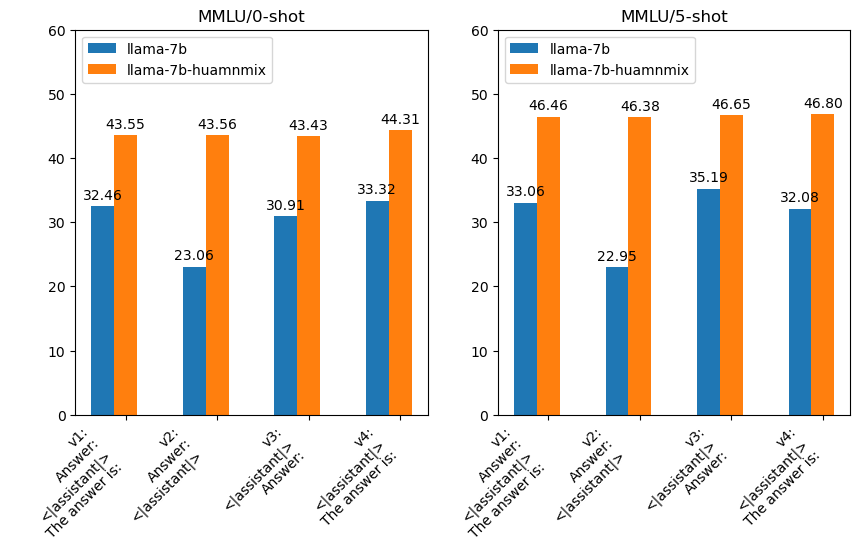

In [74]:
import numpy as np

x_labels = [
    'Answer:\n<|assistant|>\nThe answer is:',
    'Answer:\n<|assistant|>\n',
    '<|assistant|>\nAnswer:',
    '<|assistant|>\nThe answer is:',
]
x_labels = [f'v{i+1}:\n{x}' for i,x in enumerate(x_labels)]

dfc = df.copy()
dfc = df.filter(regex='_v|run')

runs = dfc['run_name'].to_list()[::-1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for axi, task in enumerate(['MMLU/0-shot', 'MMLU/5-shot']):

    ax = axs[axi]
    cols = [f'{task}_v{x}' for x in [1, 2, 3, 4]]
    x = np.arange(len(x_labels))

    width = .25
    multiplier = 0

    for run in runs:
        offset = width*multiplier
        y = dfc[dfc['run_name']==run][cols].to_numpy().squeeze()
        rects = ax.bar(x+offset, y, width, label=run)
        ax.bar_label(rects, padding=3, fmt='{:.2f}')
        multiplier += 1

    ax.set_title(task)
    ax.set_xticks(x+width)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.legend(loc='upper left')
    ax.set_ylim(0, 60)



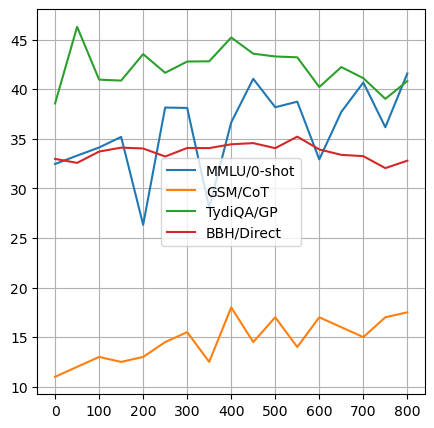

In [7]:
import matplotlib.pyplot as plt
dfc = df.copy()

# add base model performance
dfc.loc[dfc['model_args.model_name_or_path']=='huggyllama/llama-7b', 'model_args.model_name_or_path'] = 'checkpoint-0'
# get steps 
dfc.insert(0, 'steps', dfc['model_args.model_name_or_path'].apply(lambda x: int(x.split('-')[-1])))
dfc = dfc.sort_values('steps')


y_labels = [
    'MMLU/0-shot', 
    'GSM/CoT', 
    'TydiQA/GP',
    'BBH/Direct',
    # 
#     'GSM/Direct', 
#     'Codex-Eval/Pass@1', 
#     'TydiQA/CB',
]


fig, ax = plt.subplots(1,1,figsize=(5,5))

x = dfc['steps']
for y_label in y_labels:
    y = dfc[y_label].to_numpy()
    ax.plot(x, y, label=y_label)
ax.legend()
ax.grid()

In [11]:

total_data_points = 200000 # 10000, 50000, 100000, 200000
subsample_mixture_list = []
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {'cot': 0.48785105, 'flan_v2': 0.48785105, 'dolly': 0.00732313, 'oasst1': 0.01697478}.items())
] # humanmix mixture.
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {"cot": 0.360595703125, "dolly": 0.0021991729736328125, "flan_v2": 0.63037109375, "oasst1": 0.0016956329345703125}.items())
] # pythia-1.4b humanmix_uniform:200k_doremiv1.json

subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {"cot": 0.2254638671875, "dolly": 0.01409149169921875, "flan_v2": 0.1739501953125, "oasst1": 0.59423828125}.items())
] # pythia-1.4b humanmix_uniform:200k_doremiv2.json

subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {"cot": 0.08563232421875, "dolly": 0.54296875, "flan_v2": 0.347900390625, "oasst1": 0.0103302001953125}.items())
] # llama-7b_humanmix_uniform:200k_doremiv2.json
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {"cot": 0.0316162109375, "dolly": 0.204833984375, "flan_v2": 0.40966796875, "oasst1": 0.40966796875}.items()
        )] # llama-7b_humanmix_uniform:600k_doremiv2.json
subsample_mixture_list

[{'cot': 97570, 'flan_v2': 97570, 'dolly': 1464, 'oasst1': 3394},
 {'cot': 72119, 'dolly': 439, 'flan_v2': 126074, 'oasst1': 339},
 {'cot': 45092, 'dolly': 2818, 'flan_v2': 34790, 'oasst1': 118847},
 {'cot': 17126, 'dolly': 108593, 'flan_v2': 69580, 'oasst1': 2066},
 {'cot': 6323, 'dolly': 40966, 'flan_v2': 81933, 'oasst1': 81933}]

In [12]:
6323+40966+81933+81933

211155

In [83]:
# exp_dir = 'results/ft1'

# d = {
#     'bbh_s=0': 'bbh_s=3',
#     'gsm': 'gsm_s=8_cot',
#     'mmlu': 'mmlu_s=0',
#     'tydiqa_cb': 'tydiqa_s=1_cb',
#     'tydiqa_gp': 'tydiqa_s=1_gp',
# }

# d.update({k+'_chatfmt': v+'_chatfmt' for k,v in d.items()})

# for subdir in os.listdir(exp_dir):    
#     for task_name_src, task_name_tgt in d.items():
#         path_src = os.path.join(exp_dir, subdir, 'eval', task_name_src)
#         path_tgt = os.path.join(exp_dir, subdir, 'eval', task_name_tgt)
#         if os.path.isdir(path_src):
# #             os.rename(path_src, path_tgt)
#             print(path_src)
#             print(path_tgt)


In [66]:

dfc = df.copy()
dfc.insert(0, 'total_train_samples',  dfc['data_args.subsample_mixture'].apply(
    lambda d: sum(list(d.values())) if d else 200000))
# dfc[dfc['total_train_samples'].apply(
#     lambda x: total_train_samples-500<x<total_train_samples+500)]
dfc

,total_train_samples,model_args.model_name_or_path,data_args.subsample_mixture,MMLU/0-shot,GSM/Direct,GSM/CoT,BBH/Direct,Codex-Eval/Pass@1,TydiQA/CB,TydiQA/GP,Average,ranking
0,200804,results/baselines/huggyllama/llama-7b,"{'cot': 15356, 'dolly': 894, 'flan_v2': 182740, 'oasst1': 1814}",44.601909,3.5,14.0,37.147236,1.829268,9.934316,44.361673,22.196343,-2.1250
1,200128,results/baselines/gpt2-medium,"{'cot': 22540, 'dolly': 2790, 'flan_v2': 174520, 'oasst1': 278}",23.123487,4.0,1.5,29.677548,0.609756,1.543347,8.898066,9.907458,-9.2500
2,100000,gpt2-medium,{'flan_v2': 100000},23.002421,3.5,3.0,29.757914,0.000000,1.821590,8.841241,9.989024,-9.7500
3,100000,gpt2-medium,{'self_instruct': 100000},23.557898,4.0,2.5,29.590479,1.219512,1.410211,6.140904,9.774144,-10.3125
4,200000,gpt2-medium,"{'cot': 50000, 'dolly': 50000, 'flan_v2': 50000, 'oasst1': 50000}",22.938328,5.0,1.5,29.973845,0.000000,1.875094,7.962404,9.892810,-11.0625
5,200804,results/baselines/gpt2-medium,"{'cot': 15356, 'dolly': 894, 'flan_v2': 182740, 'oasst1': 1814}",23.045150,3.0,3.5,30.422551,0.000000,1.395340,7.712177,9.867888,-11.2500
6,50000,results/baselines/gpt2-medium,"{'cot': 12500, 'dolly': 12500, 'flan_v2': 12500, 'oasst1': 12500}",22.952571,3.0,3.0,30.284956,0.000000,1.896922,7.082380,9.745261,-11.8750
7,199992,gpt2-medium,"{'baize': 16666, 'code_alpaca': 16666, 'cot': 16666, 'dolly': 16666, 'flan_v2': 16666, 'gpt4_alpaca': 16666, 'oasst1': 16666, 'self_instruct': 16666, 'sharegpt': 16666, 'stanford_alpaca': 16666, 'super_ni': 16666, 'unnatural_instructions': 16666}",23.016664,2.5,3.0,29.758117,1.219512,1.367148,7.950251,9.830242,-12.0625
8,99999,gpt2-medium,"{'cot': 40031, 'dolly': 6009, 'flan_v2': 40031, 'oasst1': 13928}",23.023786,2.5,2.5,29.827929,0.000000,2.158432,7.918454,9.704086,-12.0625
9,100000,gpt2-medium,{'super_ni': 100000},23.151973,2.5,2.5,29.258770,0.000000,1.877706,7.116692,9.486449,-13.6875


In [16]:


dfc = df.copy()
dfc.columns = [x.split('_')[0] for x in dfc.columns]
def get_dataset(x):
    x = x.split('+')
    if len(x) == 1:
        return ''
    else:
        d = x[1]
        d = d.replace('_', '')
        return d
dfc['Dataset'] = dfc['Model'].apply(get_dataset)
order_list = ['',
 'superni', 'cot', 'flanv2', 'dolly', 'oasst1',
 'selfinstruct', 'unnaturalinstructions', 'stanfordalpaca', 'codealpaca', 'gpt4alpaca',
 'baize', 'sharegpt', 'humanmix', 'h+gptmix']
dfc['order'] = dfc['Dataset'].map({v: i for i, v in enumerate(order_list)})
dfc = dfc.sort_values('order')
dfc = dfc.drop(columns=['order', 'Dataset'])
dfc = dfc.reset_index(drop=True)

display(dfc[dfc['Model'].apply(lambda x: 'llama-7b' in x and ':' not in x)]
        .style
        .background_gradient(cmap ='coolwarm')
        .format(precision=1))


display(dfc[dfc['Model'].apply(
            lambda x: 'llama-7b' in x and (
                ':' in x or any(c in x for c in ['dolly', 'oasst1', 'cot', 'flan'])
                or 'humanmix' in x
            )
        )]
        .style
        .background_gradient(cmap ='coolwarm')
        .format(precision=1))

display(dfc[dfc['Model'].apply(lambda x: 'llama2-7b' in x or 'llama-7b'==x)]
        .style
        .background_gradient(cmap ='coolwarm')
        .format(precision=1))


KeyError: '`Styler.apply` and `.applymap` are not compatible with non-unique index or columns.'

/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


KeyError: '`Styler.apply` and `.applymap` are not compatible with non-unique index or columns.'

KeyError: '`Styler.apply` and `.applymap` are not compatible with non-unique index or columns.'

,Model,MMLU/0-shot,GSM/CoT,BBH/Direct,Codex-Eval/Pass@1
0,llama-7b,32.459764,11.0,32.970313,5.487805
4,llama-7b+dolly,37.231164,13.0,30.603476,11.585366
5,llama-7b+oasst1,34.147557,7.5,29.692361,2.439024
14,llama-7b+dolly:oasst1,37.900584,7.0,30.150571,9.146341


In [ ]:
{"dataset": "flan_v2", "id": "flan_v2_2", "messages": [{"role": "user", "content": "Tratatul de la Lisabona nu face inutil referire, pentru prima dată în istoria Uniunii Europene, la drepturile persoanelor care aparţin acestor minorităţi şi la valorile proprii acestora.\n\nWhich language is this?\n"}, {"role": "assistant", "content": "Romanian"}]}
{"dataset": "flan_v2", "id": "flan_v2_2", "messages": [{"role": "user", "content": "Tratatul de la Lisabona nu face inutil referire, pentru prima dat\u0103 \u00een istoria Uniunii Europene, la drepturile persoanelor care apar\u0163in acestor minorit\u0103\u0163i \u015fi la valorile proprii acestora.\n\nWhich language is this?\n"}, {"role": "assistant", "content": "Romanian"}]}


In [ ]:
with pd.option_context('display.float_format', '{:0.1f}'.format):
    display(df[['Model']+[x for x in df.columns if 'chatfmt' in x]])

In [ ]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(df[[x for x in df.columns if 'chatfmt' not in x]])


In [ ]:
import glob

models = []
models += ['t5-small', 't5-base', 't5-large', 't5-3b', 't5-11b']
models += ['huggyllama/llama-7b']
save_dirs = [f'../results/baselines/{x}/eval/gsm/' for x in models]

data = []
for model, save_dir in zip(models, save_dirs):
    logfile_path = glob.glob(os.path.join(save_dir, '*.out'))[0]
    out = get_run_statistics(logfile_path)
    with open(os.path.join(save_dir, 'metrics.json'), 'r') as f:
        metrics = json.load(f)
    data.append((model, out['cpu_time']/60/60, out['avg_mem'], out['max_mem'], metrics['exact_match']))
    

import pandas as pd
columns = ['name', 'cpu_time (hr)', 'avg_mem', 'max_mem', 'exact_match']
df = pd.DataFrame(data, columns=columns)
df

In [ ]:


df

